Avant de lancer ce NB, je lance le terminal Anaconda et je copie colle : 
mlflow server --host 127.0.0.1 --port 8080 

Ca lance MLFlow

Pour ce projet, nous avons suivi le schéma présenté dans cet article:
https://towardsdatascience.com/a-complete-machine-learning-walk-through-in-python-part-one-c62152f39420

# 1 - Imports


In [16]:
import mlflow
from mlflow.tracking import MlflowClient

from PIL import Image
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import time

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, roc_auc_score, f1_score, fbeta_score, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler

import imblearn
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

import lightgbm as lgb

from mlflow.models import infer_signature
from lightgbm import early_stopping

import shap
# Memory management
import gc 

import streamlit as st

In [17]:

print(matplotlib.__version__)

3.8.0


In [18]:
print(pd.__version__)

2.1.4


In [19]:
print(imblearn.__version__)

0.12.3


In [20]:
# démarrage du tracking
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

In [21]:
# Configuration de la connexion MLflow
mlflow.utils.rest_utils.DEFAULT_RETRIES = 10
mlflow.utils.rest_utils.DEFAULT_BACKOFF_FACTOR = 0.2
mlflow.utils.rest_utils.DEFAULT_TIMEOUT = 60

In [22]:
# Vérifiez que le serveur MLflow est accessible
try:
    mlflow.get_experiment_by_name("MLflow Credit_Scoring - Projet_7")
    print("Le serveur MLflow est accessible.")
except Exception as e:
    print(f"Erreur de connexion au serveur MLflow: {e}")

Le serveur MLflow est accessible.


In [23]:
train_reduced=pd.read_csv('train_reduced.csv')

In [24]:
train_reduced.head()

,EXT_SOURCE_1,CREDIT_TERM,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_EMPLOYED,DAYS_BIRTH,client_installments_AMT_PAYMENT_min_sum,AMT_ANNUITY,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_ENDDATE_max,...,client_credit_CNT_DRAWINGS_POS_CURRENT_max_sum,client_credit_AMT_PAYMENT_CURRENT_min_sum,previous_NAME_SELLER_INDUSTRY_Industry_mean,client_credit_AMT_INST_MIN_REGULARITY_max_sum,previous_NAME_GOODS_CATEGORY_Sport and Leisure_mean,client_credit_CNT_DRAWINGS_POS_CURRENT_min_sum,client_credit_NAME_CONTRACT_STATUS_Completed_mean_min,OCCUPATION_TYPE_Drivers,TARGET,SK_ID_CURR
0,0.083037,0.060749,0.262949,0.139376,-637.0,9461,175783.73,24700.5,-103.0,780.0,...,NaN,NaN,0.0,NaN,0.0,NaN,NaN,False,True,100002
1,0.311267,0.027598,0.622246,NaN,-1188.0,16765,1154108.20,35698.5,-606.0,1216.0,...,NaN,NaN,0.0,NaN,0.0,NaN,NaN,False,False,100003
2,NaN,0.050000,0.555912,0.729567,-225.0,19046,16071.75,6750.0,-408.0,-382.0,...,NaN,NaN,0.0,NaN,0.0,NaN,NaN,False,False,100004
3,NaN,0.094941,0.650442,NaN,-3039.0,19005,994476.70,29686.5,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,100006
4,NaN,0.042623,0.322738,NaN,-3038.0,19932,483756.38,21865.5,-1149.0,-783.0,...,NaN,NaN,0.0,NaN,0.0,NaN,NaN,False,False,100007


In [25]:
test_reduced=pd.read_csv('test_reduced.csv')

In [26]:
train_reduced.shape, test_reduced.shape

((307511, 349), (48744, 348))

In [27]:
train_reduced=train_reduced.drop(['AMT_CREDIT', 'AMT_ANNUITY', 'CREDIT_TERM'], axis=1)
test_reduced=test_reduced.drop(['AMT_CREDIT', 'AMT_ANNUITY', 'CREDIT_TERM'], axis=1)

In [28]:
train_reduced.shape, test_reduced.shape

((307511, 346), (48744, 345))

In [29]:
train_reduced['TARGET'].value_counts()

TARGET
False    282686
True      24825
Name: count, dtype: int64

# 2 - Préparation des données

In [30]:
train_r, val_r = train_test_split(train_reduced, test_size=0.2, random_state=42)

# Extraire les identifiants, les cibles et les caractéristiques pour les ensembles d'entraînement et de test
X_train_r = train_r.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y_train_r = train_r['TARGET']
id_train_r = train_r['SK_ID_CURR']

X_val_r = val_r.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y_val_r = val_r['TARGET']
id_val_r = val_r['SK_ID_CURR']

test_r=test_reduced.drop('SK_ID_CURR', axis=1)
id_test_r = test_reduced['SK_ID_CURR']
    

In [31]:
X_train_r.shape, X_val_r.shape, test_r.shape, y_train_r.shape, y_val_r.shape, id_train_r.shape, id_val_r.shape, id_test_r.shape

((246008, 344),
 (61503, 344),
 (48744, 344),
 (246008,),
 (61503,),
 (246008,),
 (61503,),
 (48744,))

In [32]:
def prepare_modelisation (X_train, X_val, test) :

    # Create a label encoder object
    le = LabelEncoder()
    
    # Iterate through the columns and label encode if object type and nunique <=2
    for col in X_train.columns:
        if X_train[col].dtype == 'object' and len(list(X_train[col].unique())) <= 2:
            # Apply the label encoder to both training and test sets
            X_train[col] = le.fit_transform(X_train[col])
            X_val[col] = le.transform(X_val[col])
            test[col] = le.transform(test[col])
            

               
    # one-hot encoding of categorical variables
    X_train = pd.get_dummies(X_train)
    X_val = pd.get_dummies(X_val)
    test = pd.get_dummies(test)
    

    # Assurons-nous que X_train et X_test ont les mêmes colonnes
    X_train, X_val = X_train.align(X_val, join='inner', axis=1)
    X_train, test = X_train.align(test, join='inner', axis=1)
    
   
    # Median imputation of missing values
    imputer = SimpleImputer(strategy = 'median')

    # Scale each feature to 0-1
    scaler = MinMaxScaler(feature_range = (0, 1))

    X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
    X_val = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)
    test = pd.DataFrame(imputer.transform(test), columns=test.columns)
    
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
    test = pd.DataFrame(scaler.transform(test), columns=test.columns)

   
    return X_train, X_val, test

In [33]:
X_train_r, X_val_r, test_r=prepare_modelisation (X_train_r, X_val_r, test_r)

In [34]:
X_train_r.shape, X_val_r.shape, test_r.shape, y_train_r.shape, y_val_r.shape, id_train_r.shape, id_val_r.shape, id_test_r.shape

((246008, 344),
 (61503, 344),
 (48744, 344),
 (246008,),
 (61503,),
 (246008,),
 (61503,),
 (48744,))

# 3 - Consolidation du jeu de test préparé

Regroupement des données préparées pour passer en modélisation + leur ID

In [35]:
reconstituted_test=pd.concat([id_test_r, test_r], axis=1) 

In [36]:
reconstituted_test.head()

,SK_ID_CURR,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_EMPLOYED,DAYS_BIRTH,client_installments_AMT_PAYMENT_min_sum,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_ENDDATE_max,client_cash_CNT_INSTALMENT_FUTURE_mean_max,...,client_bureau_balance_STATUS_1_count_mean,ORGANIZATION_TYPE_Bank,client_credit_CNT_DRAWINGS_POS_CURRENT_max_sum,client_credit_AMT_PAYMENT_CURRENT_min_sum,previous_NAME_SELLER_INDUSTRY_Industry_mean,client_credit_AMT_INST_MIN_REGULARITY_max_sum,previous_NAME_GOODS_CATEGORY_Sport and Leisure_mean,client_credit_CNT_DRAWINGS_POS_CURRENT_min_sum,client_credit_NAME_CONTRACT_STATUS_Completed_mean_min,OCCUPATION_TYPE_Drivers
0,100001,0.787623,0.923573,0.177549,0.869975,0.662458,0.004063,0.983231,0.597295,0.024390,...,0.004329,0.0,0.000000,0.0,0.0,0.006084,0.0,0.0,0.0,0.0
1,100005,0.587395,0.341118,0.482907,0.750502,0.596110,0.006343,0.978782,0.591081,0.087805,...,0.000000,0.0,0.000000,0.0,0.0,0.006084,0.0,0.0,0.0,0.0
2,100013,0.524898,0.818464,0.681715,0.751117,0.707384,0.009792,0.585900,0.565197,0.322493,...,0.053030,0.0,0.000000,0.0,0.0,0.041439,0.0,0.0,0.0,1.0
3,100028,0.545502,0.596114,0.683628,0.895824,0.365671,0.025190,0.907940,0.995716,0.141768,...,0.000000,0.0,0.088608,0.0,0.0,0.030216,0.0,0.0,0.0,0.0
4,100038,0.200177,0.497880,0.599166,0.877680,0.312909,0.019498,0.896988,0.585400,0.071295,...,0.000000,0.0,0.000000,0.0,0.0,0.006084,0.0,0.0,0.0,0.0


In [37]:
reconstituted_test.shape

(48744, 345)

In [38]:
reconstituted_test.to_csv('reconstituted_test.csv', index=False)

# **FONCTION DU NB 1 A SUPPRIMER QUAND ON GROUPERA LES NB**

In [39]:
def custom_f1(y_true, y_pred_proba):
    thresholds = np.linspace(0, 1, 100)
    best_threshold = 0.5
    best_f1 = 0
    best_cost = float('inf')
    
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        f1 = f1_score(y_true, y_pred)
        # Calculer les coûts
        fn = np.sum((y_true == 1) & (y_pred == 0))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        cost = fn * 10 + fp
        
        # Sélectionner le seuil basé sur le coût le plus bas
        if cost < best_cost:
            best_f1 = f1
            best_threshold = threshold
            best_cost = cost
    
    return best_f1

In [40]:


def custom_recall(y_true, y_pred_proba):
    thresholds = np.linspace(0, 1, 100)
    best_threshold = 0.5
    best_recall = 0
    best_cost = float('inf')
    
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        recall = recall_score(y_true, y_pred)
        # Calculer les coûts
        fn = np.sum((y_true == 1) & (y_pred == 0))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        cost = fn * 10 + fp
        
        # Sélectionner le seuil basé sur le coût le plus bas
        if cost < best_cost:
            best_recall = recall
            best_threshold = threshold
            best_cost = cost
    
    return best_recall

In [41]:
# Fonction pour run la grid search. J'y ajoute le fit_params dans le quel j'ajouterai l'early stopping pour le lgbm

def run_grid_search(X_train, y_train, model, param_grid, fit_params=None, train_size=1.0):
    # Définir les scorers personnalisés
    scorers = {
        'AUC': 'roc_auc',
        'F1_opt': make_scorer(custom_f1, needs_proba=True),
        'recall_opt': make_scorer(custom_recall, needs_proba=True)
    }

    # Créer un pipeline avec SMOTE et le modèle
    pipeline = Pipeline([
        ('sampling', SMOTE(random_state=42)),
        ('model', model)
    ])

    # Mettre à jour le param_grid pour correspondre au pipeline
    # Les paramètres du modèle doivent être préfixés par 'model__'
    param_grid = {f'model__{key}': value for key, value in param_grid.items()}

    grid_search = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        scoring=scorers,
        refit='AUC',
        cv=2,
        verbose=3,
        return_train_score=True
    )

     # Fractionnement des données si train_size < 1.0
    if train_size < 1.0:
        X_train_sample, _, y_train_sample, _ = train_test_split(X_train, y_train, train_size=train_size, random_state=42)
        data_to_fit = (X_train_sample, y_train_sample)
    else:
        data_to_fit = (X_train, y_train)

    # Entraînement
    start_time = time.time()
    grid_search.fit(*data_to_fit)
    end_time = time.time()

    execution_time = round(end_time - start_time, 2)
    print(f"Le temps d'execution est de {execution_time} secondes.")

    return {
        'best_model' : grid_search.best_estimator_,
        'best_params_': grid_search.best_params_,
        'best_score_': grid_search.best_score_,
        'cv_results_': grid_search.cv_results_
    }

In [42]:
def extract_best_auc_result(results):
    """
    Extracts the best model configuration based on AUC score from the cv_results of a GridSearchCV.
    
    Parameters:
    - results (dict): A dictionary output from the run_grid_search function containing 'cv_results_'.
    
    Returns:
    - DataFrame: A DataFrame containing the best scoring row based on the AUC rank.
    """
    # Conversion of cv_results_ into a DataFrame
    cv_results = results['cv_results_']
    df_cv_results = pd.DataFrame(cv_results)
    
    # Sorting the DataFrame by the rank of the AUC test scores
    df_cv_results = df_cv_results.sort_values(by="rank_test_AUC", ascending=True)
    
    # Returning the top entry
    return df_cv_results.head(1)

In [43]:
def plot_auc_scores(best_auc_result):
    """
    Plots the AUC scores from cross-validation folds for the best model configuration based on rank.
    
    Parameters:
    - best_auc_result (DataFrame): A DataFrame with the top row from cv_results_ sorted by AUC.
    - full_cv_results (DataFrame): The full cv_results DataFrame to extract mean scores for rank 1.
    """
    # Extract the AUC scores for each fold for the best AUC configuration
    df_train_results_auc = best_auc_result[[
        'split0_train_AUC', 
        'split1_train_AUC', 
        # 'split2_test_AUC', 
        # 'split3_test_AUC', 
        # 'split4_test_AUC'
    ]][best_auc_result['rank_test_AUC'] == 1].values
    
    df_test_results_auc = best_auc_result[[
        'split0_test_AUC', 
        'split1_test_AUC', 
        # 'split2_test_AUC', 
        # 'split3_test_AUC', 
        # 'split4_test_AUC'
    ]][best_auc_result['rank_test_AUC'] == 1].values
    
    fig, ax = plt.subplots(figsize=(8, 4))
    
    # Plot the train scores
    ax.plot(range(0, 2), df_test_results_auc.reshape(-1), label='Scores de validation')
    
    # Plot the test scores
    ax.plot(range(0, 2), df_train_results_auc.reshape(-1), label='Scores de train')

    # # Plot the average for the combinations with rank_test_AUC == 1
    # mean_scores_rank_1 = best_auc_result.loc[best_auc_result['rank_test_AUC'] == 1, 'mean_test_AUC']
    # ax.axhline(y=mean_scores_rank_1.values[0], color='g', linestyle='--', label='Moyenne (rank 1)')
    
    # Set the properties of the axis
    ax.set_xticks(range(0, 2))
    ax.set_xlabel("Folds de cross-validation")
    ax.set_ylabel('AUC')
    ax.set_title("AUC de chaque fold \n pour la combinaison d'hyperparamètres \n qui arrive au rang 1 en terme d'AUC", fontsize=15, weight="bold", fontname="Impact", color="#0e2452")
    
    # Add a legend
    ax.legend()

    fig.tight_layout()
    
    plt.show()


In [44]:
# fonction qui va établir un seuil pour convertir les probabiliiéts en étiquettes de classe binaire. 
# à partir de la matrice de confusion, on va calculer le coût

def calculate_cost_threshold(y_true, probas, threshold, cost_fn, cost_fp):
    y_pred = (probas >= threshold).astype(int) # transforme les probas en prédictions binaires en utilisant un seuil. 
                                                # Les probabilités >= au seuil sont marquées comme 1 (positives),
                                                # les autres comme 0 (négatives).

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel() # .ravel() convertit la matrice 2x2 en un tableau à une dimension [tn, fp, fn, tp]
                                                            # permet une extraction facile de chaque valeur
    return cost_fn * fn + cost_fp * fp

In [45]:
def evaluate_model (X_train, y_train, X_test, y_test, best_model):

    start_predict_time = time.time()
    # Predict on the training data
    y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]
    
    # Predict on the test data
    y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]

    end_predict_time = time.time()

    # Calculate AUC for training and test data
    auc_train = round(roc_auc_score(y_train, y_train_pred_proba),2)
    auc_test = round(roc_auc_score(y_test, y_test_pred_proba),2)

    # Find the optimal threshold for cost function on the training data
    thresholds = np.linspace(0, 1, 100)
    costs = [calculate_cost_threshold(y_test, y_test_pred_proba, thr, cost_fn=10, cost_fp=1) for thr in thresholds]
    optimal_threshold = round(thresholds[np.argmin(costs)],2) 

    # Metrics at the optimal threshold
    y_test_pred_opt = (y_test_pred_proba >= optimal_threshold).astype(int)
    
    f1_score_1_test = f1_score(y_test, y_test_pred_opt)
    recall_1_test = recall_score(y_test, y_test_pred_opt)
    accuracy_test = accuracy_score(y_test, y_test_pred_opt)
    
    return {
        'predicting_execution_time': round(end_predict_time - start_predict_time, 2),
        'auc_train': auc_train,
        'auc_test': auc_test,
        'optimal_threshold': optimal_threshold,
        'f1_score_1_test': round(f1_score_1_test,2),
        'recall_1_test': round(recall_1_test,2),
        'accuracy_test': round(accuracy_test,2)
    }

In [46]:
def show_feature_importances(importances, features):
    # Création du DataFrame

    importances = importances.flatten()
    
    feature_importances = pd.DataFrame({
        'feature': features, 
        'importance': importances
    })
    
    # Tri et sélection des 20 caractéristiques les plus importantes
    feature_importances_sorted = feature_importances.sort_values(by='importance', ascending=False).reset_index(drop=True)
    feature_importances_sorted = feature_importances_sorted.head(20)
    
    # Normalisation des importances
    feature_importances_sorted['importance_normalized'] = feature_importances_sorted['importance'] / feature_importances_sorted['importance'].sum()
    
    # Création du graphique à barres horizontales
    plt.figure(figsize=(10, 6))
    ax = plt.subplot()
    
    # Inversion de l'index pour afficher la plus importante en haut
    indices = list(reversed(list(feature_importances_sorted.index)))
    ax.barh(indices, feature_importances_sorted['importance_normalized'], align='center', edgecolor='k')
    
    # Définition des étiquettes y
    ax.set_yticks(indices)
    ax.set_yticklabels(feature_importances_sorted['feature'])
    
    # Étiquetage du graphique
    plt.xlabel('Normalized Importance')
    plt.title('Top 20 Feature Importances')
    plt.show()
    
    return feature_importances_sorted

# Exemple d'utilisation
# importances = [valeur1, valeur2, ..., valeurN] # remplacez par vos valeurs d'importance réelles
# features = ['nom1', 'nom2', ..., 'nomN'] # remplacez par vos noms de caractéristiques réels
# feature_importances_sorted = plot_feature_importances(importances, features)


# **FIN DES FONCTIONS DU NB 1 A SUPPRIMER QUAND ON GROUPERA LES NB**

# 3 - Nouvelle modélisation LGBM avec features = 95% de l'importance

In [47]:
model_LGBM_2 = lgb.LGBMClassifier(objective='binary',
                                boosting_type = 'goss',
                                # class_weight = 'balanced',
                                random_state = 50)
        
param_grid_LGBM_2 = {
    'num_leaves': [35,40],
    'n_estimators' : [150,200],   
    'learning_rate' : [0.07, 0.1],
}

# Paramètres pour early_stopping
fit_params = {
    'eval_metric': 'auc',
    'callbacks': [early_stopping(stopping_rounds=50)]
}

In [48]:
# Execution de la fonction
start_training_time = time.time()

results_LGBM_2 = run_grid_search(X_train_r, y_train_r, model_LGBM_2, param_grid_LGBM_2,fit_params)

end_training_time = time.time()

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 113066, number of negative: 113066
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.908732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87435
[LightGBM] [Info] Number of data points in the train set: 226132, number of used features: 344
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore

In [49]:
training_execution_time = round(end_training_time - start_training_time,2)  
print(f"Le temps d'exécution est de {training_execution_time} secondes.")

Le temps d'exécution est de 1070.43 secondes.


In [50]:
best_model_lgbm_2 = results_LGBM_2['best_model']
best_params_lgbm_2 = results_LGBM_2['best_params_']
best_score_lgbm_2 = results_LGBM_2['best_score_']
cv_results_lgbm_2 = results_LGBM_2['cv_results_']

print("Best Params:", best_params_lgbm_2)
print("Best AUC:", best_score_lgbm_2)

Best Params: {'model__learning_rate': 0.07, 'model__n_estimators': 200, 'model__num_leaves': 40}
Best AUC: 0.7647839072310056


In [51]:
best_auc_result_LGBM_2 = extract_best_auc_result(results_LGBM_2)
best_auc_result_LGBM_2.head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__learning_rate,param_model__n_estimators,param_model__num_leaves,params,split0_test_AUC,split1_test_AUC,...,std_train_F1_opt,split0_test_recall_opt,split1_test_recall_opt,mean_test_recall_opt,std_test_recall_opt,rank_test_recall_opt,split0_train_recall_opt,split1_train_recall_opt,mean_train_recall_opt,std_train_recall_opt
3,51.475748,0.382508,8.048762,0.177487,0.07,200,40,"{'model__learning_rate': 0.07, 'model__n_estim...",0.763732,0.765835,...,0.009518,0.67901,0.64027,0.65964,0.01937,4,0.742302,0.775408,0.758855,0.016553


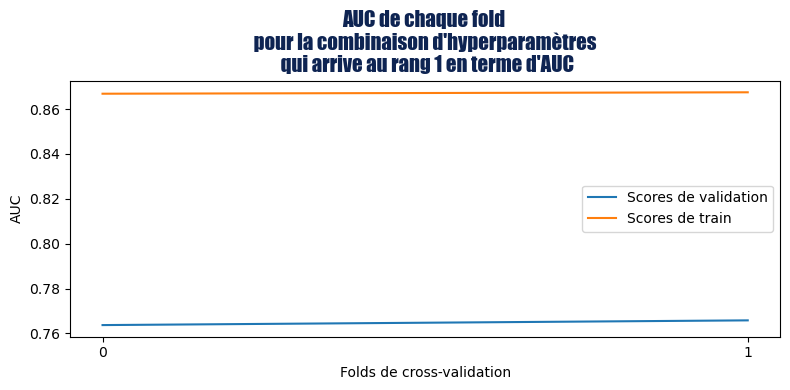

In [52]:
plot_auc_scores(best_auc_result_LGBM_2)

In [53]:
result_lgbm_2=evaluate_model (X_train_r, y_train_r, X_val_r, y_val_r, best_model_lgbm_2)
result_lgbm_2

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


{'predicting_execution_time': 4.05,
 'auc_train': 0.82,
 'auc_test': 0.77,
 'optimal_threshold': 0.09,
 'f1_score_1_test': 0.28,
 'recall_1_test': 0.69,
 'accuracy_test': 0.71}

In [54]:
# Sauvegarde de l'optimal threshold dans un fichier text pour réutilisation dans le script streamlit
optimal_threshold = result_lgbm_2['optimal_threshold']

# Sauvegarde de l'optimal threshold dans un fichier texte
with open('optimal_threshold.txt', 'w') as f:
    f.write(str(optimal_threshold))


In [55]:
best_model_lgbm_2.named_steps['model']

LGBMClassifier(boosting_type='goss', learning_rate=0.07, n_estimators=200,
               num_leaves=40, objective='binary', random_state=50)

In [56]:
# Utiliser un échantillon de 10 lignes comme exemple d'entrée
input_example = X_train_r.sample(n=10, random_state=42)

# 4 - Enregistrement du modèle dans MLFlow

In [57]:
# Création d'une nouvelle expérience MLflow
mlflow.set_experiment("MLflow Credit_Scoring - Projet_7")

# Commencer une session MLflow
with mlflow.start_run():
    # Log les hyperparameters que j'ai déclarés au dessus
    mlflow.log_params(best_params_lgbm_2)

    # Log les métriques
    
    mlflow.log_metric("optimal_threshold", result_lgbm_2['optimal_threshold'])

    mlflow.log_metric("recall_1_test", result_lgbm_2['recall_1_test'])
    mlflow.log_metric("f1_score_1_test", result_lgbm_2['f1_score_1_test'])
    mlflow.log_metric("accuracy du test", result_lgbm_2['accuracy_test'])
    
    mlflow.log_metric("auc_train", result_lgbm_2['auc_train'])
    mlflow.log_metric("auc_test", result_lgbm_2['auc_test'])
    
    mlflow.log_metric("temps_fit", training_execution_time)
    mlflow.log_metric("temps_predict", result_lgbm_2['predicting_execution_time'])


    # Définir un tag pour se rappeler l'objet de cette session
    mlflow.set_tag("Training Info", "LGBM with 95% importance features")

    # Infer the model signature
    signature = infer_signature(X_train_r, best_model_lgbm_2.predict(X_train_r)) # infer_signature génère automatiquement une "signature" 
                                                              # qui décrit les entrées et les sorties du modèle. 
                                                              # Cela inclut les types de données et les formats attendus par le modèle, 
                                                              # facilitant ainsi l'intégration et la réutilisation du modèle 
                                                              # dans différents environnements.

    
    # Log le model
    model_info = mlflow.lightgbm.log_model(
        lgb_model=best_model_lgbm_2.named_steps['model'], # le modèle
        artifact_path="lgbm_classifier_model", # le chemin où le modèle sera enregistré
        signature=signature, # la signature du modèle
        input_example=input_example, # un exemple d'input pour montrer comment invoquer le modèle
        registered_model_name="scoring-credit-lgbm_classifier", # nom sous lequel le modèle est enregistré dans le registre de modèles MLflow
    )
    
    # Afficher l'URI du modèle
    model_uri = model_info.model_uri
    print(f"Model URI: {model_uri}")



[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


Registered model 'scoring-credit-lgbm_classifier' already exists. Creating a new version of this model...
2024/07/22 15:57:40 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: scoring-credit-lgbm_classifier, version 25


Model URI: runs:/837e66d6ebf943b5b464ee5e16862781/lgbm_classifier_model


Created version '25' of model 'scoring-credit-lgbm_classifier'.


# 5 - Interprétation des résultats

## 5.1 - Feature Importance

In [58]:
importances = best_model_lgbm_2.named_steps['model'].feature_importances_
features= X_train_r.columns

In [59]:
importances

array([164, 186, 198,  77, 104, 104,  58,  61,  37,  64,  33,  51,  35,
        29,  30,  44,  30,  72,  88,  16,  20,  54,  24,  15,  24,  23,
        63,  36,  21,  32,  23,  43,  11,  15,  39,  26,  23,  15,  27,
        12,  35,  18,  37,  13,  20,  11,  15,  36,  19, 185,  15,  42,
        22,  46,  14,  12,   4,  13,  12,  29,  31,  12,   7,  14,  10,
         6,  36,  35, 118,  14,  10,  15,  12,  67,  12,  11,  10,   6,
        10,   8,  13,  30, 115,  41,  44,  28,  10,   8,  11,   8,  35,
        19,  15,  16,  23,  13,  20,  14,   8,  44, 119,   8,   1,  16,
        92,   9,  16,  10,  12,   7,  11,  26,  11,   4,   7,   6,   5,
         4,   9,  31,  16,   7,  11,  19,  28, 175,  11,  25,   6,  13,
         7,  50,  41,   8,   4,   7,  95, 114,   5,  20,   6,   7,  38,
        17,   8,   7,   9,   3,  13,  60,   5,   8,   7,  16,  41,   5,
         7,   6,   5,   6,  13,  40,  11,   4,  11,  52,   8,   8,   5,
        11,  10,  25,  20,  24,   3,   3,  14,  10,   9,   5,   

In [60]:
X_train_r.head(1)

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_EMPLOYED,DAYS_BIRTH,client_installments_AMT_PAYMENT_min_sum,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_ENDDATE_max,client_cash_CNT_INSTALMENT_FUTURE_mean_max,OWN_CAR_AGE,...,client_bureau_balance_STATUS_1_count_mean,ORGANIZATION_TYPE_Bank,client_credit_CNT_DRAWINGS_POS_CURRENT_max_sum,client_credit_AMT_PAYMENT_CURRENT_min_sum,previous_NAME_SELLER_INDUSTRY_Industry_mean,client_credit_AMT_INST_MIN_REGULARITY_max_sum,previous_NAME_GOODS_CATEGORY_Sport and Leisure_mean,client_credit_CNT_DRAWINGS_POS_CURRENT_min_sum,client_credit_NAME_CONTRACT_STATUS_Completed_mean_min,OCCUPATION_TYPE_Drivers
0,0.544382,0.419378,0.629055,0.908106,0.894025,0.098148,0.795003,0.583347,0.312084,0.340659,...,0.007576,0.0,0.0,0.004319,0.0,0.047359,0.0,0.0,0.0,0.0


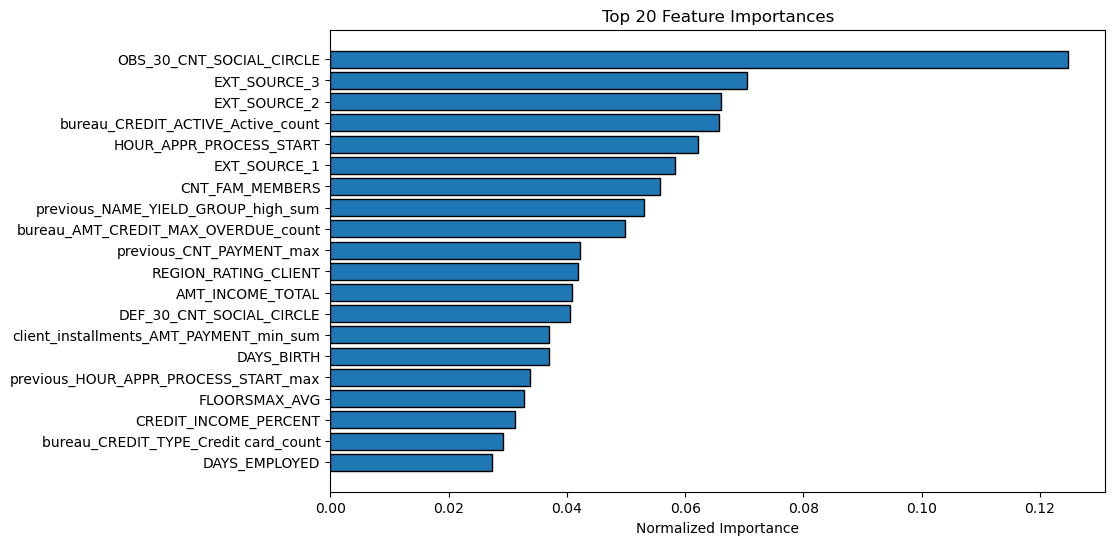

,feature,importance,importance_normalized
0,OBS_30_CNT_SOCIAL_CIRCLE,351,0.124778
1,EXT_SOURCE_3,198,0.070387
2,EXT_SOURCE_2,186,0.066122
3,bureau_CREDIT_ACTIVE_Active_count,185,0.065766
4,HOUR_APPR_PROCESS_START,175,0.062211
5,EXT_SOURCE_1,164,0.058301
6,CNT_FAM_MEMBERS,157,0.055812
7,previous_NAME_YIELD_GROUP_high_sum,149,0.052968
8,bureau_AMT_CREDIT_MAX_OVERDUE_count,140,0.049769
9,previous_CNT_PAYMENT_max,119,0.042304


In [61]:
show_feature_importances(importances, features)

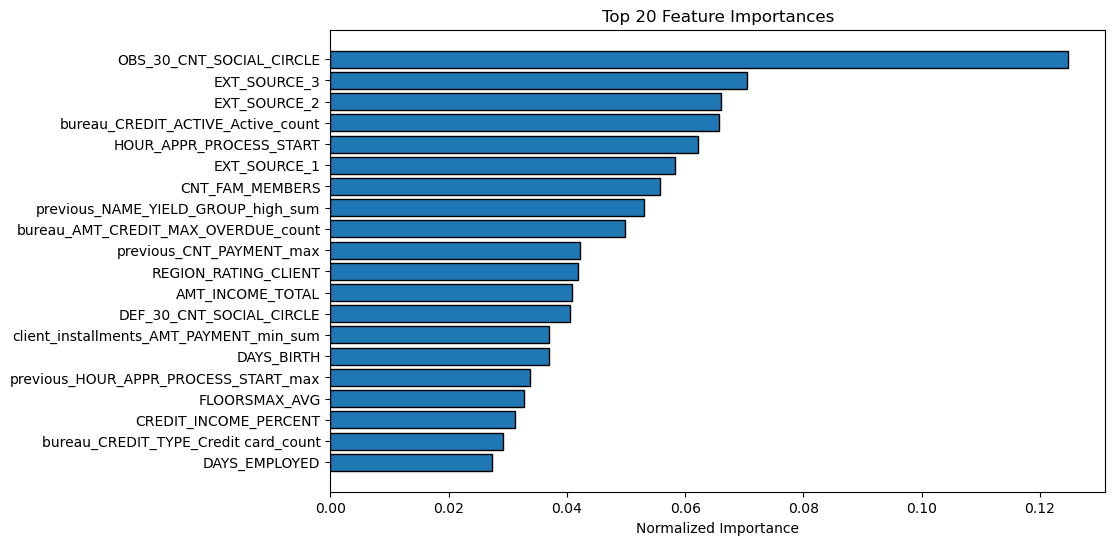

In [62]:
feature_importances_sorted=show_feature_importances(importances, features)

In [63]:
feature_importances_sorted

,feature,importance,importance_normalized
0,OBS_30_CNT_SOCIAL_CIRCLE,351,0.124778
1,EXT_SOURCE_3,198,0.070387
2,EXT_SOURCE_2,186,0.066122
3,bureau_CREDIT_ACTIVE_Active_count,185,0.065766
4,HOUR_APPR_PROCESS_START,175,0.062211
5,EXT_SOURCE_1,164,0.058301
6,CNT_FAM_MEMBERS,157,0.055812
7,previous_NAME_YIELD_GROUP_high_sum,149,0.052968
8,bureau_AMT_CREDIT_MAX_OVERDUE_count,140,0.049769
9,previous_CNT_PAYMENT_max,119,0.042304


In [64]:
feature_importances_sorted.to_csv('feature_importances_sorted_lgbm_2.csv', index=False)

## 5.2 - Shap Values

### 5.2.1 - Interprétation globale du test

In [65]:
# on s'assure que le meilleur modèle est extrait de la pipeline
best_model=best_model_lgbm_2.named_steps['model']

In [66]:
# Initialisation de l'Explainer SHAP avec le meilleur modèle obtenu sur le jeu de données de test original
explainer = shap.Explainer(best_model)

In [67]:
# Calcul des valeurs SHAP sur les données de test
shap_values = explainer.shap_values(X_val_r)

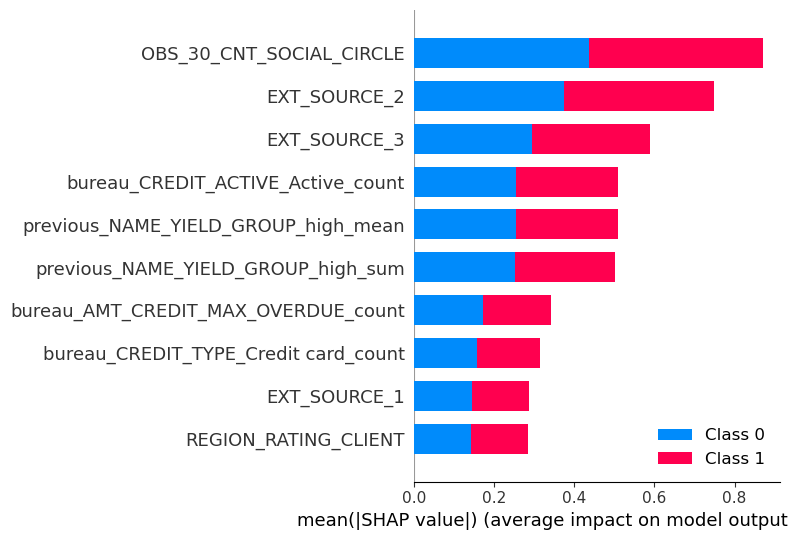

In [68]:
# Créer un graphique récapitulatif SHAP pour l'ensemble des données transformées
shap.summary_plot(shap_values, X_val_r, 
                  plot_type="bar",
                 max_display=10)

Si on regarde ce qui se passe pour la classe 1 :

In [69]:
shap_values_class1 = shap_values[1]

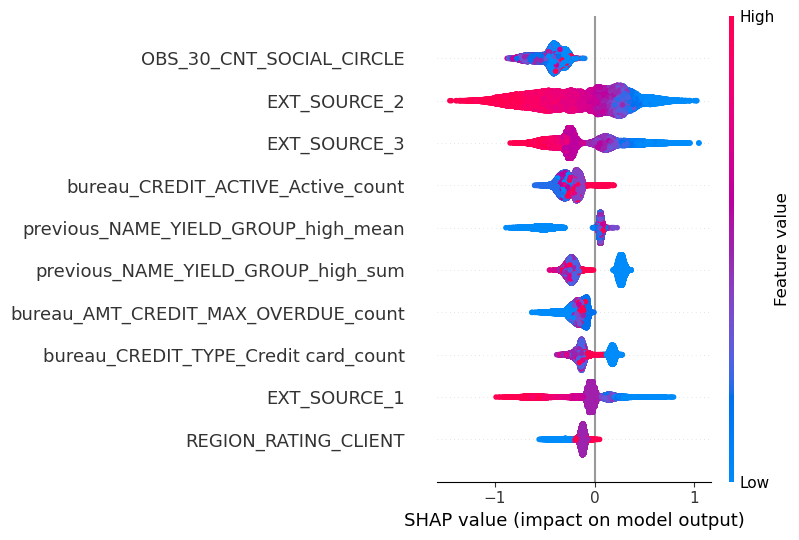

In [70]:
# Graphique récapitulatif SHAP pour la classe 1
shap.summary_plot(shap_values_class1, 
                  X_val_r, 
                  max_display=10)

### 5.2.2 - Interprétation locale

In [71]:
# verif
train_reduced[train_reduced['SK_ID_CURR']==100002]

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_EMPLOYED,DAYS_BIRTH,client_installments_AMT_PAYMENT_min_sum,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_ENDDATE_max,client_cash_CNT_INSTALMENT_FUTURE_mean_max,OWN_CAR_AGE,...,client_credit_CNT_DRAWINGS_POS_CURRENT_max_sum,client_credit_AMT_PAYMENT_CURRENT_min_sum,previous_NAME_SELLER_INDUSTRY_Industry_mean,client_credit_AMT_INST_MIN_REGULARITY_max_sum,previous_NAME_GOODS_CATEGORY_Sport and Leisure_mean,client_credit_CNT_DRAWINGS_POS_CURRENT_min_sum,client_credit_NAME_CONTRACT_STATUS_Completed_mean_min,OCCUPATION_TYPE_Drivers,TARGET,SK_ID_CURR
0,0.083037,0.262949,0.139376,-637.0,9461,175783.73,-103.0,780.0,15.0,NaN,...,NaN,NaN,0.0,NaN,0.0,NaN,NaN,False,True,100002


In [72]:
val_r[val_r['SK_ID_CURR']==100002]

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_EMPLOYED,DAYS_BIRTH,client_installments_AMT_PAYMENT_min_sum,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_ENDDATE_max,client_cash_CNT_INSTALMENT_FUTURE_mean_max,OWN_CAR_AGE,...,client_credit_CNT_DRAWINGS_POS_CURRENT_max_sum,client_credit_AMT_PAYMENT_CURRENT_min_sum,previous_NAME_SELLER_INDUSTRY_Industry_mean,client_credit_AMT_INST_MIN_REGULARITY_max_sum,previous_NAME_GOODS_CATEGORY_Sport and Leisure_mean,client_credit_CNT_DRAWINGS_POS_CURRENT_min_sum,client_credit_NAME_CONTRACT_STATUS_Completed_mean_min,OCCUPATION_TYPE_Drivers,TARGET,SK_ID_CURR
0,0.083037,0.262949,0.139376,-637.0,9461,175783.73,-103.0,780.0,15.0,NaN,...,NaN,NaN,0.0,NaN,0.0,NaN,NaN,False,True,100002


In [73]:
# predict proba avec le best model
y_val_pred_proba = best_model_lgbm_2.predict_proba(X_val_r)[:, 1]

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


In [74]:
# Find the optimal threshold for cost function on the training data
thresholds = np.linspace(0, 1, 100)
costs = [calculate_cost_threshold(y_val_r, y_val_pred_proba, thr, cost_fn=10, cost_fp=1) for thr in thresholds]
optimal_threshold = round(thresholds[np.argmin(costs)],2) 

# Metrics at the optimal threshold
y_val_pred_opt = (y_val_pred_proba >= optimal_threshold).astype(int)

In [75]:
optimal_threshold

0.09

In [76]:
val_r['target_pred']=y_val_pred_opt
val_r['proba']=y_val_pred_proba

val_r[val_r['SK_ID_CURR']==100002]

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_EMPLOYED,DAYS_BIRTH,client_installments_AMT_PAYMENT_min_sum,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_ENDDATE_max,client_cash_CNT_INSTALMENT_FUTURE_mean_max,OWN_CAR_AGE,...,previous_NAME_SELLER_INDUSTRY_Industry_mean,client_credit_AMT_INST_MIN_REGULARITY_max_sum,previous_NAME_GOODS_CATEGORY_Sport and Leisure_mean,client_credit_CNT_DRAWINGS_POS_CURRENT_min_sum,client_credit_NAME_CONTRACT_STATUS_Completed_mean_min,OCCUPATION_TYPE_Drivers,TARGET,SK_ID_CURR,target_pred,proba
0,0.083037,0.262949,0.139376,-637.0,9461,175783.73,-103.0,780.0,15.0,NaN,...,0.0,NaN,0.0,NaN,NaN,False,True,100002,1,0.286929


In [77]:
pd.crosstab(y_val_r, y_val_pred_opt, rownames=['Classes réelles'], colnames=['Classes prédites'])

Classes prédites,0,1
Classes réelles,,
False,40143,16411
True,1514,3435


In [78]:
print(classification_report(y_val_r, y_val_pred_opt))

              precision    recall  f1-score   support

       False       0.96      0.71      0.82     56554
        True       0.17      0.69      0.28      4949

    accuracy                           0.71     61503
   macro avg       0.57      0.70      0.55     61503
weighted avg       0.90      0.71      0.77     61503



#### 5.2.2.1 - Interprétation d'un individu prédit en classe 1

In [79]:
val_r[val_r['target_pred']==1].shape, val_r[val_r['target_pred']==0].shape

((19846, 348), (41657, 348))

In [80]:
val_r[val_r['target_pred']==1].head()

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_EMPLOYED,DAYS_BIRTH,client_installments_AMT_PAYMENT_min_sum,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_ENDDATE_max,client_cash_CNT_INSTALMENT_FUTURE_mean_max,OWN_CAR_AGE,...,previous_NAME_SELLER_INDUSTRY_Industry_mean,client_credit_AMT_INST_MIN_REGULARITY_max_sum,previous_NAME_GOODS_CATEGORY_Sport and Leisure_mean,client_credit_CNT_DRAWINGS_POS_CURRENT_min_sum,client_credit_NAME_CONTRACT_STATUS_Completed_mean_min,OCCUPATION_TYPE_Drivers,TARGET,SK_ID_CURR,target_pred,proba
245895,0.675878,0.604894,0.000527,-762.0,13297,30195.406,-129.0,231.0,6.0,19.0,...,0.0,NaN,0.0,NaN,NaN,False,False,384575,1,0.220546
36463,0.527239,0.531760,0.207964,-639.0,17907,77640.880,-399.0,1189.0,5.0,4.0,...,0.0,NaN,0.0,NaN,NaN,False,False,142232,1,0.222253
226343,NaN,0.519127,0.104795,NaN,19130,374056.030,-154.0,211.0,17.5,NaN,...,0.0,NaN,0.0,NaN,NaN,False,False,362171,1,0.164039
181469,NaN,0.012588,0.490258,-260.0,10801,NaN,-557.0,904.0,NaN,12.0,...,NaN,NaN,NaN,NaN,NaN,False,False,310328,1,0.369996
76671,NaN,0.574664,0.180888,NaN,22532,43717.094,-51.0,894.0,30.5,NaN,...,0.0,279927.0,0.0,0.0,0.0,False,False,188909,1,0.314531


In [81]:
# ID de l'individu à analyser
specific_id = 384575

In [82]:
# Trouver l'index de cet individu dans le jeu de données de test
index = val_r[val_r['SK_ID_CURR'] == specific_id].index[0]

In [83]:
# Réinitialiser les index de X_test_r pour obtenir des index consécutifs
X_val_r_reset = X_val_r.reset_index(drop=True)

# Réinitialiser les index de test_r pour obtenir des index consécutifs
val_r_reset = val_r.reset_index(drop=True)

Cette étape assure que les index sont consécutifs et commencent à 0, ce qui facilite l'alignement.

In [84]:
# Trouver le nouvel index relatif dans le jeu de données réinitialisé
relative_index = val_r_reset[val_r_reset['SK_ID_CURR'] == specific_id].index[0]

Cette ligne de code trouve l'index relatif de l'individu spécifique dans test_r_reset.

In [85]:
# Vérifier les dimensions de shap_values et X_test_r_reset 
print("Dimensions des shap_values pour la classe 1:", shap_values[1].shape)
print("Dimensions de X_test_r_reset:", X_val_r_reset.shape)

Dimensions des shap_values pour la classe 1: (61503, 344)
Dimensions de X_test_r_reset: (61503, 344)


In [86]:
# Extraire les valeurs SHAP pour cet individu spécifique pour la classe 1
individual_shap_values = shap_values[1][relative_index]

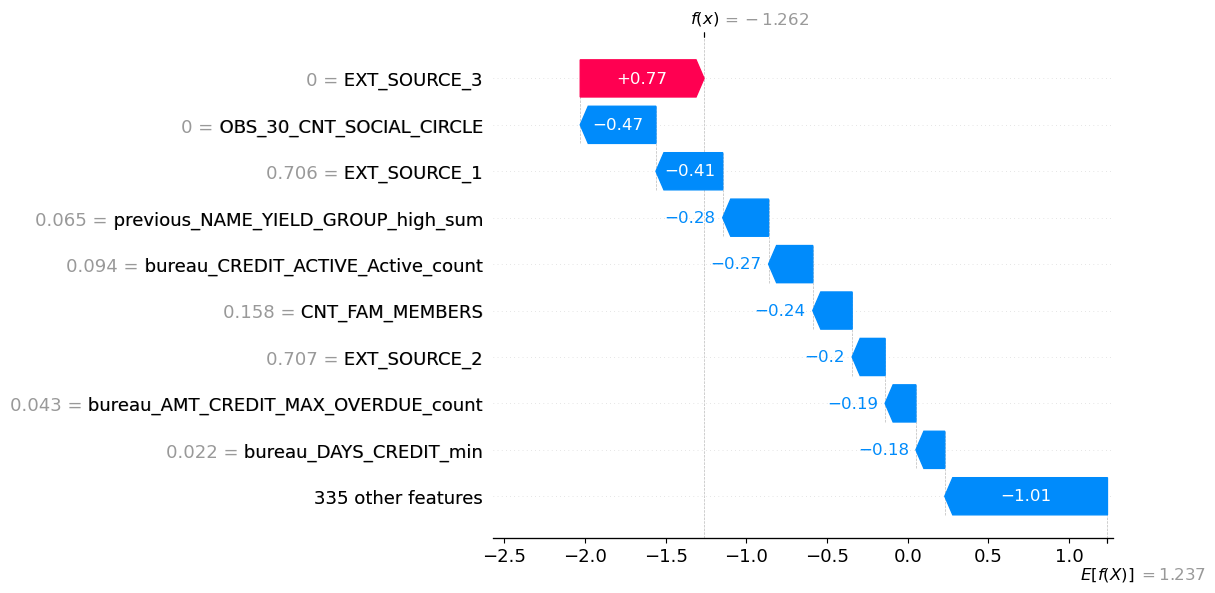

In [87]:
# Créer le graphique waterfall pour cet individu
shap.plots.waterfall(shap.Explanation(values=individual_shap_values,
                                      base_values=explainer.expected_value[1],  # Assurez-vous de choisir la bonne valeur de base
                                      data=X_val_r_reset.iloc[relative_index],  # Données de l'individu
                                      feature_names=X_val_r_reset.columns.tolist()))  # Noms des caractéristiques

#### 5.2.2.2 - Interprétation d'un individu prédit en classe 0

In [88]:
val_r[val_r['target_pred']==0].head()

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_EMPLOYED,DAYS_BIRTH,client_installments_AMT_PAYMENT_min_sum,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_ENDDATE_max,client_cash_CNT_INSTALMENT_FUTURE_mean_max,OWN_CAR_AGE,...,previous_NAME_SELLER_INDUSTRY_Industry_mean,client_credit_AMT_INST_MIN_REGULARITY_max_sum,previous_NAME_GOODS_CATEGORY_Sport and Leisure_mean,client_credit_CNT_DRAWINGS_POS_CURRENT_min_sum,client_credit_NAME_CONTRACT_STATUS_Completed_mean_min,OCCUPATION_TYPE_Drivers,TARGET,SK_ID_CURR,target_pred,proba
98194,0.430827,0.425351,0.712155,-1141.0,14778,1345559.400,-295.0,9479.0,7.666666,11.0,...,0.0,194234.77,0.0,0.0,0.00,False,False,214010,0,0.053747
249923,NaN,0.693521,0.614414,-6982.0,19626,231.660,-2185.0,-2004.0,3.120000,NaN,...,0.0,NaN,0.0,NaN,NaN,False,False,389171,0,0.037807
158389,0.654882,0.560690,0.636376,-1105.0,20327,98562.734,-217.0,1609.0,8.250000,NaN,...,0.0,0.00,0.0,0.0,0.36,False,False,283617,0,0.070426
69571,0.714067,0.547963,NaN,-345.0,15722,NaN,-727.0,-631.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,False,False,180689,0,0.041307
114736,NaN,0.077535,0.633032,NaN,23516,761519.200,-354.0,741.0,15.529411,NaN,...,0.0,NaN,0.0,NaN,NaN,False,False,233043,0,0.072432


In [89]:
# ID de l'individu à analyser
specific_id = 214010

In [90]:
# Trouver l'index de cet individu dans le jeu de données de test
index = val_r[val_r['SK_ID_CURR'] == specific_id].index[0]

In [91]:
# Réinitialiser les index de X_test_r pour obtenir des index consécutifs
X_val_r_reset = X_val_r.reset_index(drop=True)

# Réinitialiser les index de test_r pour obtenir des index consécutifs
val_r_reset = val_r.reset_index(drop=True)

In [92]:
# Trouver le nouvel index relatif dans le jeu de données réinitialisé
relative_index = val_r_reset[val_r_reset['SK_ID_CURR'] == specific_id].index[0]

In [93]:
# Extraire les valeurs SHAP pour cet individu spécifique pour la classe 0
individual_shap_values = shap_values[0][relative_index]

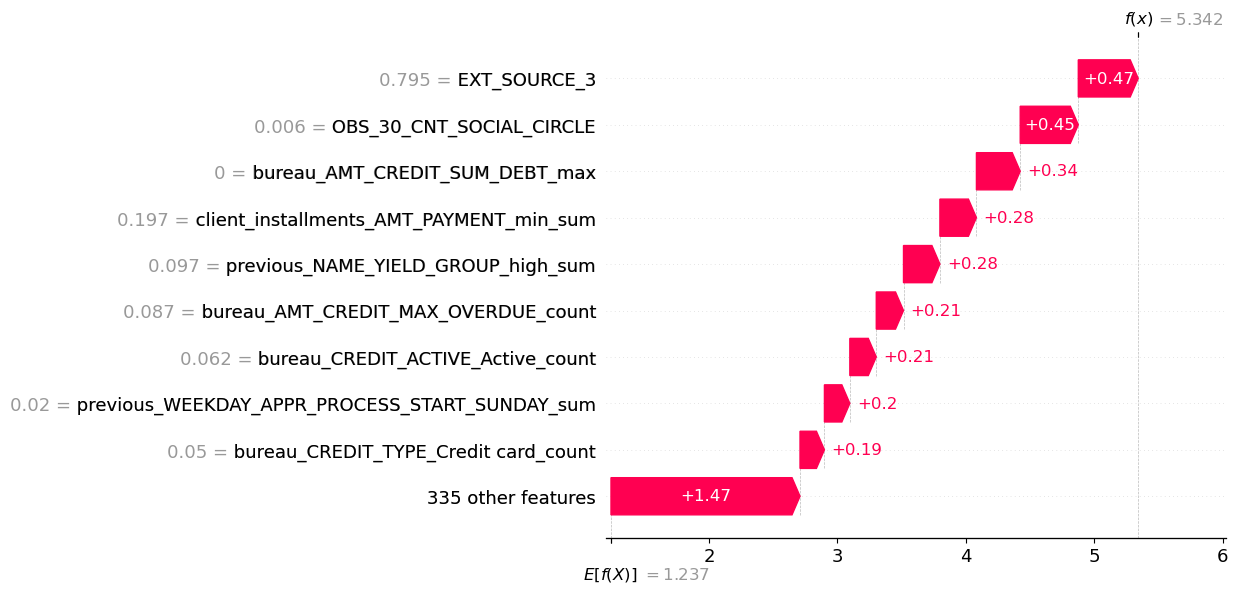

In [94]:
# Créer le graphique waterfall pour cet individu
shap.plots.waterfall(shap.Explanation(values=individual_shap_values,
                                      base_values=explainer.expected_value[1],  # Assurez-vous de choisir la bonne valeur de base
                                      data=X_val_r_reset.iloc[relative_index],  # Données de l'individu
                                      feature_names=X_val_r_reset.columns.tolist()))  # Noms des caractéristiques

In [95]:
def generate_shap_waterfall(specific_id, shap_values, test_r, explainer, X_test_r):
    """
    Génère un graphique waterfall SHAP pour un individu spécifié par son ID.
    
    Parameters:
    - specific_id : int
        L'ID de l'individu pour lequel générer le graphique.
    - shap_values : list of numpy arrays
        Les valeurs SHAP pour les classes, typiquement [shap_values_class0, shap_values_class1].
    - test_r : DataFrame
        Le DataFrame contenant les identifiants des individus et les prédictions.
    - explainer : shap.Explainer
        L'explainer SHAP utilisé pour calculer les valeurs SHAP.
    - X_test_r : DataFrame
        Le DataFrame des données de test sur lequel les valeurs SHAP ont été calculées.
    """
    # Trouver l'index de l'individu dans le jeu de données de test
    index = test_r[test_r['SK_ID_CURR'] == specific_id].index[0]

    # Réinitialiser les index de X_test_r pour obtenir des index consécutifs
    X_test_r_reset = X_test_r.reset_index(drop=True)

    # Réinitialiser les index de test_r pour obtenir des index consécutifs
    test_r_reset = test_r.reset_index(drop=True)

    # Trouver le nouvel index relatif dans le jeu de données réinitialisé
    relative_index = test_r_reset[test_r_reset['SK_ID_CURR'] == specific_id].index[0]

    # Extraire les valeurs SHAP pour cet individu spécifique
    predicted_class = test_r.loc[test_r.index[relative_index], 'target_pred']
    individual_shap_values = shap_values[predicted_class][relative_index]

    # Créer le graphique waterfall pour cet individu
    shap.plots.waterfall(shap.Explanation(values=individual_shap_values,
                                          base_values=explainer.expected_value[predicted_class],  # Assurez-vous de choisir la bonne valeur de base
                                          data=X_test_r_reset.iloc[relative_index],  # Données de l'individu
                                          feature_names=X_test_r_reset.columns.tolist()))  # Noms des caractéristiques


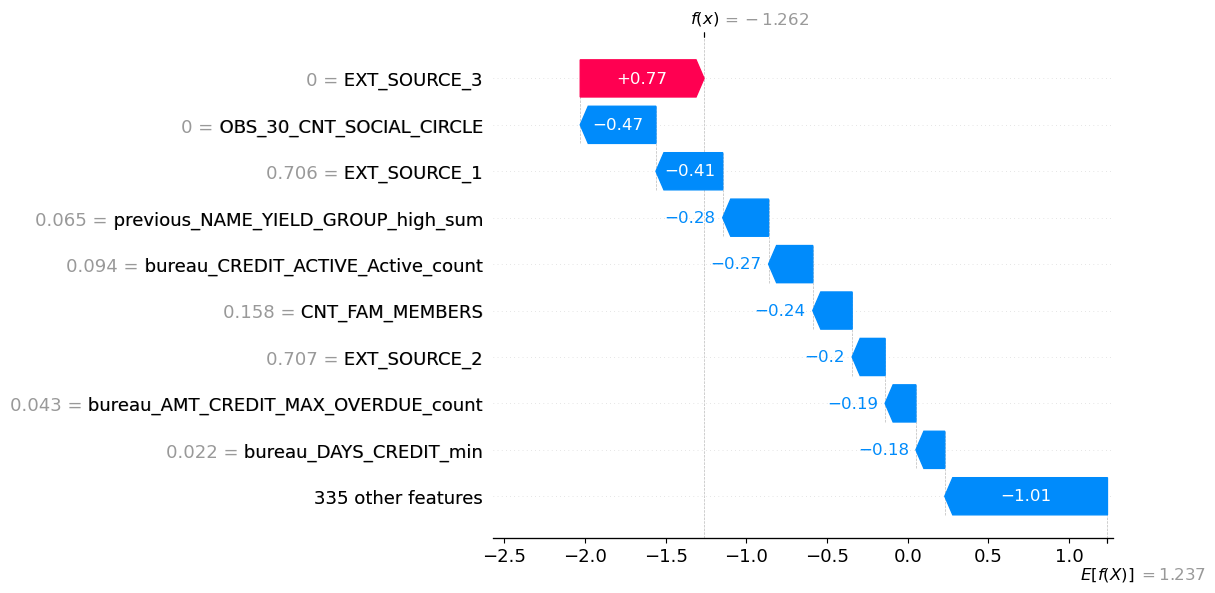

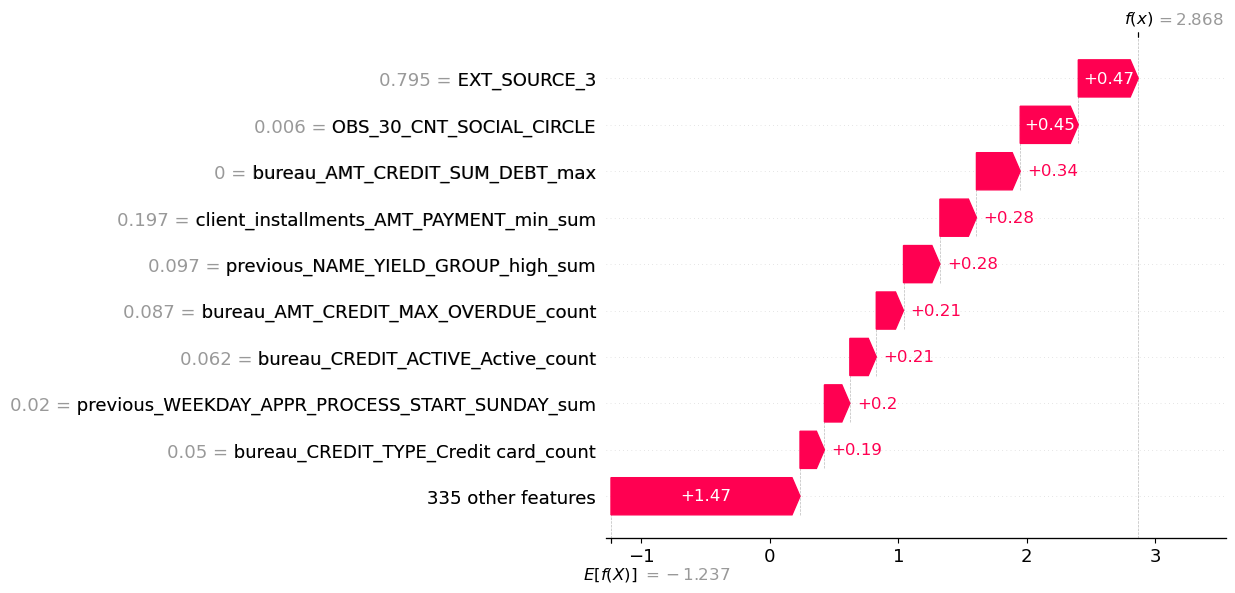

In [96]:
# Pour un individu prédit en classe 1
generate_shap_waterfall(384575, shap_values, val_r, explainer, X_val_r)

# Pour un individu prédit en classe 0
generate_shap_waterfall(214010, shap_values, val_r, explainer, X_val_r)

CONCLUSION : la suppression des variables AMT_CREDIT, AMT_ANNUITY, CREDIT_TERM n'a pas affecté la performance du modèle

Pour la suite, je me suis basée sur : https://app.livestorm.co/openclassrooms-1/deployez-une-api-de-prediction/live?s=021e19b0-cd31-4872-8b6f-b71209d05664#/chat

# 6 - Sérialisation du modèle

Sérialisation = le fait de convertir un objet qui est stocké de façon numérique sur notre mémoire ram. et le stocker sous forme de binaire sur notre ordiinateur. la pipeline était dans notre mémoire vive. On veut la stocker sous forme de fichier pour pouvoir la réutiliser plus tard

On peut sérialser en pickle ou en joblib. Avec Scikit Learn, on recommande joblib

In [97]:
import joblib

In [98]:
joblib.dump(best_model_lgbm_2, 'credit_scoring.joblib')

['credit_scoring.joblib']

# 7 - Prédictions sur le jeu de test avec le modèle enregistré dans ML Flow

## 7.1 - récupération du modèle enregistré

In [193]:
# run_id 
run_id = "5f3f18e7487f41a592b94d6a228c2fac"

# Chemin relatif vers le modèle dans les artefacts de l'exécution
artifact_path = "lgbm_classifier_model"

# Créer un client MLflow
client = MlflowClient()

# Récupérer l'URI du modèle
model_uri = f"runs:/{run_id}/{artifact_path}"
print(f"Model URI: {model_uri}")

# Charger le modèle depuis MLflow
try:
    model = mlflow.lightgbm.load_model(model_uri)
    print("Le modèle a été chargé avec succès")
except mlflow.exceptions.MlflowException as e:
    st.write(f"Erreur lors du chargement du modèle: {e}")
    st.stop()

Model URI: runs:/5f3f18e7487f41a592b94d6a228c2fac/lgbm_classifier_model


2024/07/22 16:47:36 INFO mlflow.store.artifact.artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false


Le modèle a été chargé avec succès


## 7.2 - Chargement du dataframe de test et prédiction

In [194]:
jeu_de_test=pd.read_csv('reconstituted_test.csv')
jeu_de_test.head()

,SK_ID_CURR,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_EMPLOYED,DAYS_BIRTH,client_installments_AMT_PAYMENT_min_sum,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_ENDDATE_max,client_cash_CNT_INSTALMENT_FUTURE_mean_max,...,client_bureau_balance_STATUS_1_count_mean,ORGANIZATION_TYPE_Bank,client_credit_CNT_DRAWINGS_POS_CURRENT_max_sum,client_credit_AMT_PAYMENT_CURRENT_min_sum,previous_NAME_SELLER_INDUSTRY_Industry_mean,client_credit_AMT_INST_MIN_REGULARITY_max_sum,previous_NAME_GOODS_CATEGORY_Sport and Leisure_mean,client_credit_CNT_DRAWINGS_POS_CURRENT_min_sum,client_credit_NAME_CONTRACT_STATUS_Completed_mean_min,OCCUPATION_TYPE_Drivers
0,100001,0.787623,0.923573,0.177549,0.869975,0.662458,0.004063,0.983231,0.597295,0.024390,...,0.004329,0.0,0.000000,0.0,0.0,0.006084,0.0,0.0,0.0,0.0
1,100005,0.587395,0.341118,0.482907,0.750502,0.596110,0.006343,0.978782,0.591081,0.087805,...,0.000000,0.0,0.000000,0.0,0.0,0.006084,0.0,0.0,0.0,0.0
2,100013,0.524898,0.818464,0.681715,0.751117,0.707384,0.009792,0.585900,0.565197,0.322493,...,0.053030,0.0,0.000000,0.0,0.0,0.041439,0.0,0.0,0.0,1.0
3,100028,0.545502,0.596114,0.683628,0.895824,0.365671,0.025190,0.907940,0.995716,0.141768,...,0.000000,0.0,0.088608,0.0,0.0,0.030216,0.0,0.0,0.0,0.0
4,100038,0.200177,0.497880,0.599166,0.877680,0.312909,0.019498,0.896988,0.585400,0.071295,...,0.000000,0.0,0.000000,0.0,0.0,0.006084,0.0,0.0,0.0,0.0


In [195]:
preditions_for_each=model.predict_proba(jeu_de_test.iloc[:,1:])[:, 1]

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


In [231]:
jeu_de_test['predictions']=preditions_for_each

In [232]:
jeu_de_test.sort_values(by='predictions', ascending=False)

,SK_ID_CURR,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_EMPLOYED,DAYS_BIRTH,client_installments_AMT_PAYMENT_min_sum,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_ENDDATE_max,client_cash_CNT_INSTALMENT_FUTURE_mean_max,...,ORGANIZATION_TYPE_Bank,client_credit_CNT_DRAWINGS_POS_CURRENT_max_sum,client_credit_AMT_PAYMENT_CURRENT_min_sum,previous_NAME_SELLER_INDUSTRY_Industry_mean,client_credit_AMT_INST_MIN_REGULARITY_max_sum,previous_NAME_GOODS_CATEGORY_Sport and Leisure_mean,client_credit_CNT_DRAWINGS_POS_CURRENT_min_sum,client_credit_NAME_CONTRACT_STATUS_Completed_mean_min,OCCUPATION_TYPE_Drivers,predictions
22815,265895,0.241410,0.015863,0.100162,0.954779,0.418489,0.009859,0.950034,0.596036,0.085366,...,0.0,0.000000,0.000000,0.000000,0.006084,0.0,0.0,0.000000,0.0,0.804812
5604,141025,0.005093,0.000030,0.060783,0.971192,0.290981,0.000035,0.997947,0.578542,0.060976,...,0.0,0.000000,0.000000,0.000000,0.006084,0.0,0.0,0.000000,0.0,0.782007
19555,242231,0.524898,0.375144,0.196682,0.908106,0.713754,0.012400,0.995209,0.996113,0.224085,...,0.0,0.005425,0.000201,0.000000,0.006307,0.0,0.0,0.000000,0.0,0.743156
5627,141215,0.028997,0.075769,0.599166,0.960418,0.167756,0.007844,0.896988,0.585400,0.320122,...,0.0,0.000000,0.000000,0.000000,0.006084,0.0,0.0,0.000000,0.0,0.735542
8796,164207,0.165128,0.049906,0.255009,0.951597,0.114769,0.004462,0.939767,0.593682,0.292683,...,0.0,0.019590,0.000005,0.000000,0.017215,0.0,0.0,0.000000,0.0,0.715573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8481,162037,0.877926,0.904266,0.672106,0.908106,0.754340,0.146297,0.147844,0.578857,0.243293,...,0.0,0.000000,0.000000,0.000000,0.022200,0.0,0.0,0.000000,0.0,0.004604
45351,432003,0.883335,0.830223,0.660481,0.905147,0.923337,0.111526,0.572211,0.560857,0.222222,...,0.0,0.000000,0.000000,0.000000,0.006084,0.0,0.0,0.000000,0.0,0.004472
46722,441463,0.642169,0.784831,0.823570,0.908106,0.715107,0.137825,0.800821,0.589986,0.060976,...,0.0,0.000000,0.000000,0.428571,0.006084,0.0,0.0,0.000000,0.0,0.004462
7957,158366,0.880762,0.673803,0.691248,0.718234,0.624690,0.012246,0.957906,0.581376,0.077236,...,0.0,0.002562,0.000000,0.000000,0.004889,0.0,0.0,0.470588,0.0,0.004191


In [233]:
jeu_de_test[jeu_de_test['predictions']<0.09]

,SK_ID_CURR,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_EMPLOYED,DAYS_BIRTH,client_installments_AMT_PAYMENT_min_sum,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_ENDDATE_max,client_cash_CNT_INSTALMENT_FUTURE_mean_max,...,ORGANIZATION_TYPE_Bank,client_credit_CNT_DRAWINGS_POS_CURRENT_max_sum,client_credit_AMT_PAYMENT_CURRENT_min_sum,previous_NAME_SELLER_INDUSTRY_Industry_mean,client_credit_AMT_INST_MIN_REGULARITY_max_sum,previous_NAME_GOODS_CATEGORY_Sport and Leisure_mean,client_credit_CNT_DRAWINGS_POS_CURRENT_min_sum,client_credit_NAME_CONTRACT_STATUS_Completed_mean_min,OCCUPATION_TYPE_Drivers,predictions
0,100001,0.787623,0.923573,0.177549,0.869975,0.662458,0.004063,0.983231,0.597295,0.024390,...,0.0,0.000000,0.0,0.0,0.006084,0.0,0.0,0.0,0.0,0.075639
2,100013,0.524898,0.818464,0.681715,0.751117,0.707384,0.009792,0.585900,0.565197,0.322493,...,0.0,0.000000,0.0,0.0,0.041439,0.0,0.0,0.0,1.0,0.032100
3,100028,0.545502,0.596114,0.683628,0.895824,0.365671,0.025190,0.907940,0.995716,0.141768,...,0.0,0.088608,0.0,0.0,0.030216,0.0,0.0,0.0,0.0,0.033308
5,100042,0.524898,0.735561,0.438028,0.329556,0.626550,0.269768,0.919918,0.695562,0.322493,...,0.0,0.025316,0.0,0.0,0.020720,0.0,0.0,0.0,1.0,0.052081
6,100057,0.796412,0.667935,0.726684,0.855962,0.518377,0.009994,0.884668,0.652527,0.103659,...,0.0,0.000000,0.0,0.0,0.006084,0.0,0.0,0.0,0.0,0.010009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48738,456202,0.170857,0.891640,0.268028,0.979399,0.237824,0.019444,0.943532,0.588316,0.079268,...,0.0,0.000000,0.0,0.0,0.006084,0.0,0.0,0.0,0.0,0.088132
48739,456221,0.524898,0.758567,0.717489,0.711423,0.703551,0.006247,0.961328,0.583812,0.210366,...,0.0,0.000000,0.0,0.0,0.006084,0.0,0.0,0.0,0.0,0.051303
48740,456222,0.524898,0.800697,0.599166,0.935853,0.208399,0.042342,0.896988,0.585400,0.146341,...,0.0,0.000000,0.0,0.0,0.006084,0.0,0.0,0.0,0.0,0.036792
48741,456223,0.767228,0.740082,0.316237,0.830449,0.475366,0.017548,0.925394,0.572780,0.115854,...,0.0,0.000000,0.0,0.0,0.006084,0.0,0.0,0.0,0.0,0.014532


## 7.3 - Sélection d'un individu

In [234]:
# Sélection d'un individu par son Id et récupération de toutes les variables sauf la 1ère (qui correspond à l'ID)
# l'Id ne passe pas dans le modèle
selec_indiv=jeu_de_test[jeu_de_test['SK_ID_CURR']==414915].iloc[:, 1:-1]
selec_indiv

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_EMPLOYED,DAYS_BIRTH,client_installments_AMT_PAYMENT_min_sum,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_ENDDATE_max,client_cash_CNT_INSTALMENT_FUTURE_mean_max,OWN_CAR_AGE,...,client_bureau_balance_STATUS_1_count_mean,ORGANIZATION_TYPE_Bank,client_credit_CNT_DRAWINGS_POS_CURRENT_max_sum,client_credit_AMT_PAYMENT_CURRENT_min_sum,previous_NAME_SELLER_INDUSTRY_Industry_mean,client_credit_AMT_INST_MIN_REGULARITY_max_sum,previous_NAME_GOODS_CATEGORY_Sport and Leisure_mean,client_credit_CNT_DRAWINGS_POS_CURRENT_min_sum,client_credit_NAME_CONTRACT_STATUS_Completed_mean_min,OCCUPATION_TYPE_Drivers
43268,0.530751,0.59107,0.498783,0.908106,0.725141,0.00471,0.893566,0.578707,0.085366,0.098901,...,0.010101,0.0,0.0,0.0,0.0,0.006084,0.0,0.0,0.0,0.0


## 7.4 - Prédiction sur cet individu

In [235]:
predictions_proba  = model.predict_proba(selec_indiv)[:, 1]
predictions_proba 

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


array([0.08613792])

In [236]:
result_lgbm_2['optimal_threshold']

0.09

In [237]:
# Définir les prédictions binaires basées sur le seuil optimal
prediction= (predictions_proba >= result_lgbm_2['optimal_threshold']).astype(int)
prediction

array([0])

## 7.5 - Shap pour explication de la classe 1

In [238]:
def display_shap_values(model, input_data):
    explainer = shap.Explainer(model)
    individual_shap = explainer.shap_values(input_data)
    shap_values_for_class_1 = individual_shap[1]
    waterfallplot = shap.plots.waterfall(shap.Explanation(values=shap_values_for_class_1[0], 
                                          base_values=explainer.expected_value[1], 
                                          data=input_data.iloc[0], 
                                          feature_names=input_data.columns.tolist()), show=False)
    return waterfallplot

In [239]:
waterfallplot=display_shap_values(model, selec_indiv)

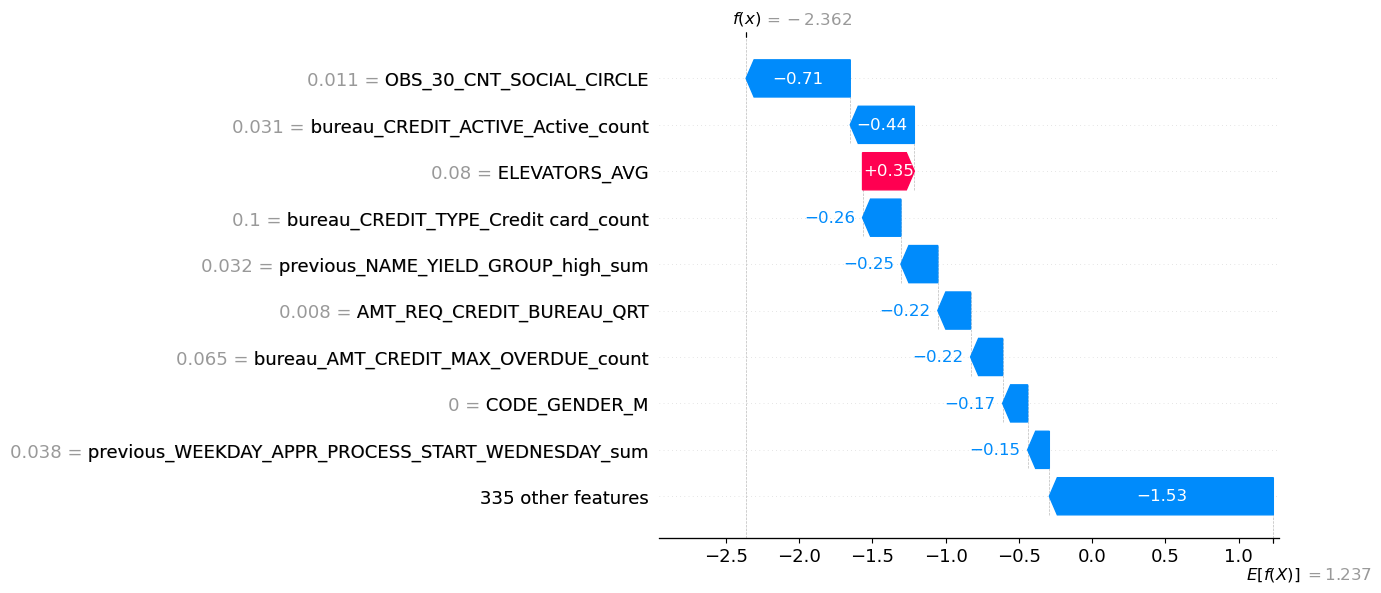

In [240]:
plt.show()

In [226]:
# Ajout des prédictions au DataFrame de test
selec_indiv['prediction_proba'] = predictions_proba
selec_indiv['prediction'] = prediction

# 8 - Déploiement du modèle en local avec Streamlit

1 - Ouvrir Anaconda Prompt : taper directement mlflow server --host 127.0.0.1 --port 8080 si ça n'a pas déjà été fait

2 - Ecriture du script streamlit : app_streamlit3.py (on l'écrit dans le bloc note et on l'enregistre en .py dans le dossier "C:\Users\belou\Projet 7 bis\input")

3 - Ouvrir un nouveau Anaconda Prompt : avec la commande cd, se positionner ici : "C:\Users\belou\Projet 7 bis\input" en copiant le chemin d'accès. puis taper : streamlit run app_streamlit3.py => ca ouvre la page Streamlit localement

4 - J'ai ensuite cliqué sur le bouton 'deploy' en haut à droite de la page streamlit ou je vais dans share.streamlit.io

5 - J'ai suivi ce tuto : https://docs.streamlit.io/deploy/streamlit-community-cloud/get-started/quickstart (je ne suis pas passée par Google mais directement via mon compte Github) :
- une fois que j'ai cliqué sur le bouton 'deploy' donc, j'ai choisi de déployer dans le streamlit community cloud (et pas custom deployment)
- j'ai renseigné le nom du repository : Dabele44/projet_7_implement_credit_scoring_model
- la branch : main
- le main file path : app_streamlit3.py

.failed with exception %s" % (url, e))
